## An Open Source E4M3 FP8 Addition Module for Accelerating Decoder-only Generative Neural Networks

```
SPDX-License-Identifier: Apache-2.0
```

Recent advancements in transformers and specialized accelerators, such as NVIDIA's H100, have revolutionized the AI landscape. The use of reduced-precision formats, like int4 and int8, significantly accelerates training and inference. However, these formats may lack the dynamic range required for NLP applications, driving the adoption of low-precision floating-point formats like FP8 [^1].


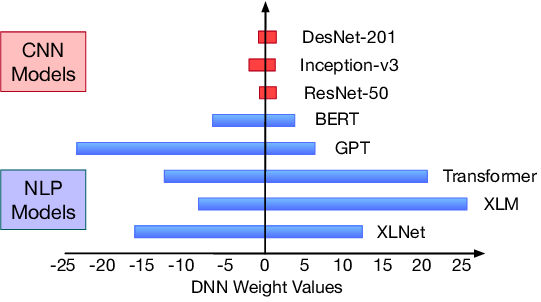

Among various FP8 formats, E4M3 stands out due to its balance between precision and dynamic range [^2], making it a superior alternative to int4 and int8 for deep learning applications, including decoder-only generative neural networks like ChatGPT. Notably, NVIDIA's H100 (Hopper) has added FP8 tensor core precision support, while dropping support for int4 and int8 formats [^3].

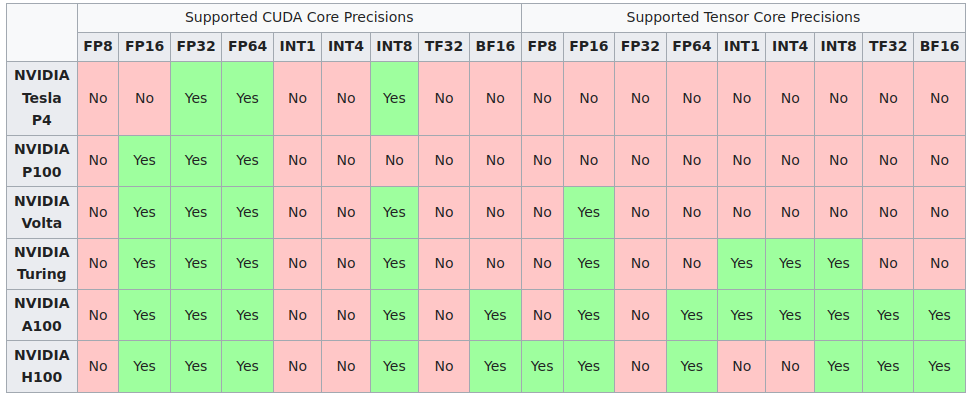

This open-source implementation empowers researchers and hardware developers to optimize and customize arithmetic operations, improving energy efficiency and performance. Additionally, it fosters widespread adoption of reduced-precision floating-point formats in deep learning applications, encouraging innovation and efficient resource utilization. As the demand f!or powerful AI solutions grows, open-source implementations like our E4M3 FP8 addition module play a vital role in democratizing AI and propelling the development of cutting-edge technologies.

--- 
Footnotes:

[^1]: FP8 Formats for Deep Learning, https://arxiv.org/abs/2209.05433

[^2]: Algorithm-Hardware Co-Design of Adaptive Floating-Point Encodings for Resilient Deep Learning Inference, https://ieeexplore.ieee.org/document/9218516

[^3]: See table showing dropping of int4 and int8 for the H100, and addition of fp8 in the H100, https://en.wikipedia.org/wiki/Hopper_(microarchitecture)


In [ ]:
#@title Install dependencies {display-mode: "form"}
#@markdown - Click the ▷ button to setup the digital design environment based on [conda-eda](https://github.com/hdl/conda-eda).

openlane_version = 'latest' #@param {type:"string"}
open_pdks_rev = '120b0bd69c745825a0b8b76f364043a1cd08bb6a' #@param {type:"string"}

if openlane_version == 'latest':
  openlane_version = ''

import os
import pathlib

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
CONDA_PREFIX = str(conda_prefix_path.resolve())
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!CI=0 bin/micromamba install --quiet --yes --prefix $CONDA_PREFIX \
                     --channel litex-hub \
                     --channel main \
                     openlane={openlane_version}
!python -m pip install gdstk tqdm
# install pdk manually: https://github.com/hdl/conda-eda/pull/238
pdk_root_path = conda_prefix_path / 'share/pdk'
pdk_root_path.mkdir(parents=True, exist_ok=True)
PDK_ROOT=str(pdk_root_path.resolve())
%env PDK_ROOT={PDK_ROOT}
!curl -L -O https://github.com/efabless/volare/releases/download/gf180mcu-{open_pdks_rev}/default.tar.xz
!xz --decompress --stdout default.tar.xz | tqdm --bytes --total=`xz --robot --list default.tar.xz | sed -n 2p | cut -f5` > default.tar
!tar -xvf default.tar -C {PDK_ROOT} gf180mcuC/ | tqdm --total=`tar -tf default.tar gf180mcuC/ | wc -l ` --null
PATH = os.environ['PATH']
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}


## Verilog

We present an open-source Verilog implementation of an E4M3 FP8 addition module, enabling seamless integration into hardware accelerators for deep learning applications. The module processes two 8-bit E4M3 FP8 inputs and generates an 8-bit E4M3 FP8 output by aligning mantissas based on exponents, adding or subtracting mantissas depending on signs, normalizing the result if necessary, and composing the output FP8 sum.

In [ ]:
%%writefile fp8_addition.v
module fp8_addition (
    input [7:0] a,
    input [7:0] b,
    output reg [7:0] fp8_sum
);

reg [7:0] a_mantissa, b_mantissa, sum_mantissa;
reg [3:0] a_exponent, b_exponent, sum_exponent;
reg a_sign, b_sign, sum_sign;
wire [4:0] exponent_diff;

assign exponent_diff = (a_exponent > b_exponent) ? a_exponent - b_exponent : b_exponent - a_exponent;

always @(*) begin
    a_sign = a[7];
    a_exponent = a[6:3];
    a_mantissa = {1'b1, a[2:0]};

    b_sign = b[7];
    b_exponent = b[6:3];
    b_mantissa = {1'b1, b[2:0]};

    // Align mantissas
    if (a_exponent > b_exponent) begin
        b_mantissa = b_mantissa >> exponent_diff;
    end else begin
        a_mantissa = a_mantissa >> exponent_diff;
    end

    // Add mantissas
    if (a_sign == b_sign) begin
        sum_mantissa = a_mantissa + b_mantissa;
        sum_sign = a_sign;
    end else begin
        if (a_mantissa > b_mantissa) begin
            sum_mantissa = a_mantissa - b_mantissa;
            sum_sign = a_sign;
        end else begin
            sum_mantissa = b_mantissa - a_mantissa;
            sum_sign = b_sign;
        end
    end

    // Normalize and adjust exponent
    if (sum_mantissa[4]) begin
        sum_mantissa = sum_mantissa >> 1;
        sum_exponent = (a_exponent > b_exponent) ? a_exponent + 1'b1 : b_exponent + 1'b1;
    end else begin
        sum_exponent = (a_exponent > b_exponent) ? a_exponent : b_exponent;
    end

    // Compose the final FP8 E4M3 sum
    fp8_sum = {sum_sign, sum_exponent, sum_mantissa[2:0]};
end

endmodule



Overwriting fp8_addition.v


In [87]:
%%writefile config.json
{
    "DESIGN_NAME": "fp8_addition",
    "VERILOG_FILES": "dir::fp8_addition.v",
    "CLOCK_TREE_SYNTH": false,
    "CLOCK_PORT": null,
    "PL_RANDOM_GLB_PLACEMENT": true,
    "FP_SIZING": "absolute",
    "DIE_AREA": "0 0 105 105",
    "PL_TARGET_DENSITY": 0.72,
    "FP_PDN_AUTO_ADJUST": false,
    "FP_PDN_VPITCH": 25,
    "FP_PDN_HPITCH": 25,
    "FP_PDN_VOFFSET": 5,
    "FP_PDN_HOFFSET": 5,
    "DIODE_INSERTION_STRATEGY": 3
}

Overwriting config.json


## Run OpenLane Flow

  

In [88]:
%env PDK=gf180mcuC
!flow.tcl -design .

env: PDK=gf180mcuC
OpenLane 2023.03.01_0_ge10820ec-conda
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[INFO]: Using configuration in 'config.json'...
[INFO]: PDK Root: /content/conda-env/share/pdk
[INFO]: Process Design Kit: gf180mcuC
[INFO]: Standard Cell Library: gf180mcu_fd_sc_mcu7t5v0
[INFO]: Optimization Standard Cell Library: gf180mcu_fd_sc_mcu7t5v0
[INFO]: Run Directory: /content/runs/RUN_2023.04.03_09.35.08
[INFO]: Preparing LEF files for the nom corner...
[STEP 1]
[INFO]: Running Synthesis (log: runs/RUN_2023.04.03_09.35.08/logs/synthesis/1-synthesis.log)...
[STEP 2]
[INFO]: Running Single-Corner Static Timing Analysis (log: runs/RUN_2023.04.03_09.35.08/logs/synthesis/2-sta.log)...
[STEP 3]
[INFO]: Running Initial Floorplanning (log: runs/RUN_2023.04.03_09.35.08/logs/floorplan/3-initial_fp.log)...
[INFO]: Floorplanned with width 91.28 and height 70.56.
[STEP 4]

## Display layout

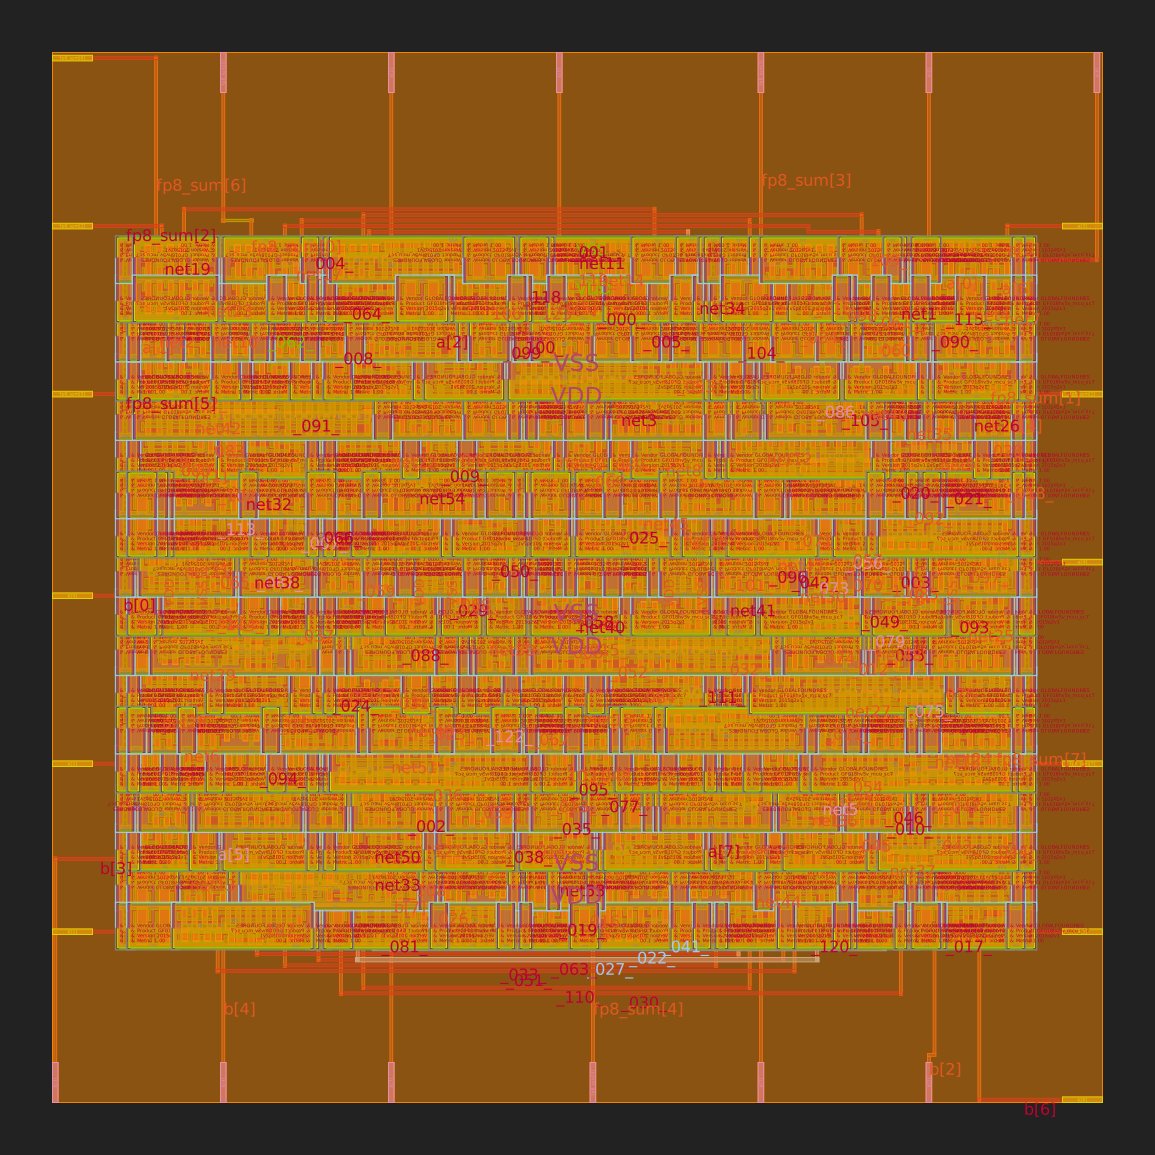

In [89]:
import pathlib
import gdstk
import IPython.display

gdss = sorted(pathlib.Path('runs').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[-1])
top_cells = library.top_level()
top_cells[0].write_svg('fp8_addition.svg')
IPython.display.SVG('fp8_addition.svg')

fp8_addition.svg

## Metrics

[Documentation](https://openlane.readthedocs.io/en/latest/reference/datapoint_definitions.html)


In [84]:
import pandas as pd
import pathlib

pd.options.display.max_rows = None
reports = sorted(pathlib.Path('runs').glob('*/reports/metrics.csv'))
df = pd.read_csv(reports[-1])
df.transpose()

,0
design,/content
design_name,fp8_addition
config,RUN_2023.04.03_09.29.07
flow_status,flow failed
total_runtime,0h0m51s0ms
routed_runtime,0h0m40s0ms
(Cell/mm^2)/Core_Util,5986.394558
DIEAREA_mm^2,0.0441
CellPer_mm^2,2993.197279
OpenDP_Util,-1
